In [1]:
import json
import gzip
import os
from os import path
import pandas as pd
import numpy as np
import datetime
import plotly.express as px 
import plotly.graph_objects as go
from IPython.core.display import display, HTML
from collections import defaultdict
import pickle

In [2]:
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return True

def read_data(path):
    data = []
    with open(path, errors='ignore') as f:
        for line in f.readlines():
            try: 
                if not is_json(line):
                    continue
                data.append(json.loads(line))
            except:
                print('bad json: ', line)
    return data

In [3]:
html_dir = "../../docs/graphs/transparency_report/"
if not path.exists(html_dir):
    try:
        os.makedirs(html_dir)
    except:
        print("Could not make directory")
        exit(1)

In [4]:
log_dir = "/home/ubuntu/jupyter/monitor/mini_explorer/data/"
json_dir = "/home/ubuntu/jupyter/harmony-log-analysis/projects/ONE_holder/credential"
files = os.listdir(log_dir)
total_gas_used = defaultdict(int)
avg_gas_limit = defaultdict(int)
avg_size = defaultdict(int)
block_time = defaultdict(dict)

In [5]:
csv_file = "data/daily_info.csv"
if path.exists(csv_file):
    df = pd.read_csv(csv_file)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
else:
    for file in files:
        if ".log" not in file and file != ".ipynb_checkpoints":
            date = file[8:]
            data = read_data(log_dir+file)
            df = pd.DataFrame(data) 
            df["timestamp"] = df["timestamp"].apply(lambda t: t.replace(" +0000 UTC",""))
            df["timestamp"] = pd.to_datetime(df['timestamp'])
            df.drop(['staking'], axis=1, inplace = True)
            df.drop_duplicates(inplace = True)
            total_gas_used[date] = df['gas'].sum()
            avg_gas_limit[date] = df['maxGas'].mean()
            avg_size[date] = df['size'].mean()
            # sort by timestamp 
            df.sort_values(by=['timestamp'], inplace = True)
            shard = []
            for name, s in df.groupby("shard"):
                shard.append(s.reset_index(drop = True))

            # calculate the average time per block, transaction_per_second
            for i in range(len(shard)):
                s = shard[i]
                s["time_diff"] = (s['timestamp']-s['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))
                s["block_diff"] = (s['block']-s['block'].shift()).fillna(0).astype(int)
                # time per block
                s["time_per_block"] = s.apply(lambda c: c["time_diff"].seconds/c["block_diff"] if c["block_diff"] != 0 else np.nan, axis = 1)
                block_time[date]["block-time-shard-{}".format(i)] = s['time_per_block'].mean()
            block_time[date]['avg-block-time'] = sum(block_time[date].values())/4

    time_df = pd.DataFrame(block_time.items(), columns=['date', 'block-time'])  
    time_df = pd.concat([time_df.drop(['block-time'], axis=1), time_df['block-time'].apply(pd.Series)], axis=1)
    used_df = pd.DataFrame(total_gas_used.items(), columns=['date', 'total-gas-used']) 
    limit_df = pd.DataFrame(avg_gas_limit.items(), columns=['date', 'avg-gas-limit']) 
    size_df = pd.DataFrame(avg_size.items(), columns=['date', 'avg-size']) 

    df = time_df.join(used_df.set_index('date'), on = 'date')
    df = df.join(limit_df.set_index('date'), on = 'date')
    df = df.join(size_df.set_index('date'), on = 'date')

    df['date'] = pd.to_datetime(df['date'], format='%Y_%m_%d')
    df.sort_values(by=['date'], inplace = True)
    df.reset_index(drop = True, inplace = True)
    df.to_csv(csv_file, index = False)

In [6]:
def draw_graph(df, feature, name, title):
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "")
    
    hover = df.columns.tolist()
    fig = px.line(df, x='date', y=feature, color_discrete_sequence = ['#99d6ff'], title = 'Harmony {} Chart'.format(title))

    fig.update_xaxes({'showgrid': False, 'showspikes': True, 'title': None})
    fig.update_yaxes({'gridcolor': "#E8E8E8"})
    fig.update_layout({'plot_bgcolor':'rgba(0,0,0,0)', "title_x": 0.5, 'hovermode': 'closest'})
#     fig.show(renderer="svg",width=800, height=500)
    fig.write_html("{:s}{:s}.html".format(html_dir, name))
    print("HTML saved in " )
    display_path = "{:s}{:s}.html".format(html_path, name)
    display(HTML("<a href='" + display_path + "' target='_blank'>" + display_path + "</a>"))
    return fig

In [7]:
def draw_area_graph(df, feature, name, title):
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "")
    
    hover = df.columns.tolist()
    fig = px.area(df, x='date', y=feature, color_discrete_sequence = ['#99d6ff'], title = 'Harmony {} Chart'.format(title))

    fig.update_xaxes({'showgrid': False, 'showspikes': True, 'title': None})
    fig.update_yaxes({'gridcolor': "#E8E8E8"})
    fig.update_layout({'plot_bgcolor':'rgba(0,0,0,0)', "title_x": 0.5, 'hovermode': 'closest'})
#     fig.show(renderer="svg",width=800, height=500)
    fig.write_html("{:s}{:s}.html".format(html_dir, name))
    print("HTML saved in " )
    display_path = "{:s}{:s}.html".format(html_path, name)
    display(HTML("<a href='" + display_path + "' target='_blank'>" + display_path + "</a>"))
    return fig

## Daily Total Gas Used

HTML saved in 


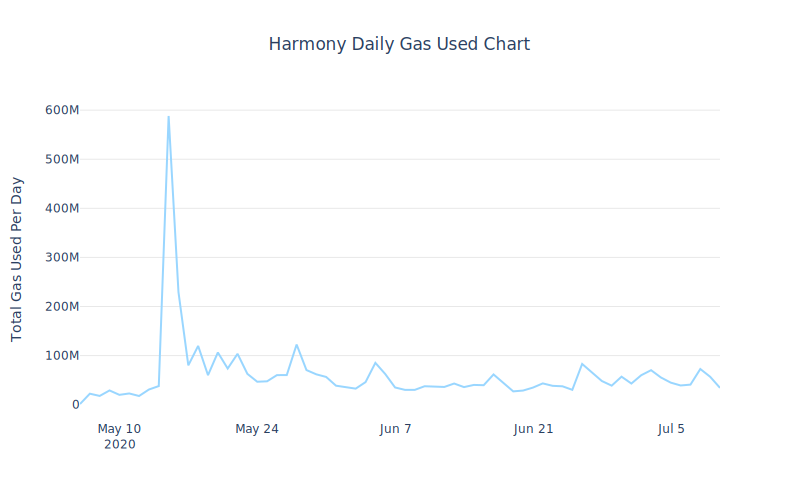

In [8]:
fig = draw_graph(df, 'total-gas-used','daily_gas_used', 'Daily Gas Used')
fig.update_layout(yaxis_title="Total Gas Used Per Day")
fig.show(renderer="svg",width=800, height=500)


## Average Gas Limit

HTML saved in 


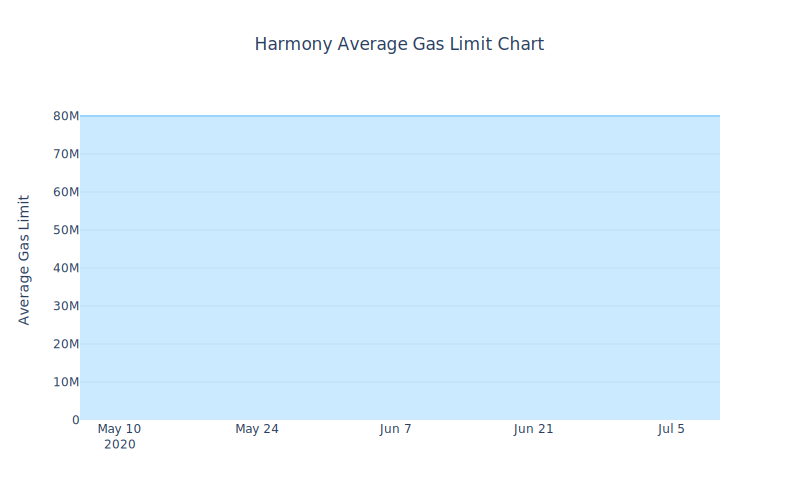

In [9]:
fig = draw_area_graph(df, 'avg-gas-limit','avg_gas_limit', 'Average Gas Limit')
fig.update_layout(yaxis_title="Average Gas Limit")
fig.show(renderer="svg",width=800, height=500)

## Average Size 

HTML saved in 


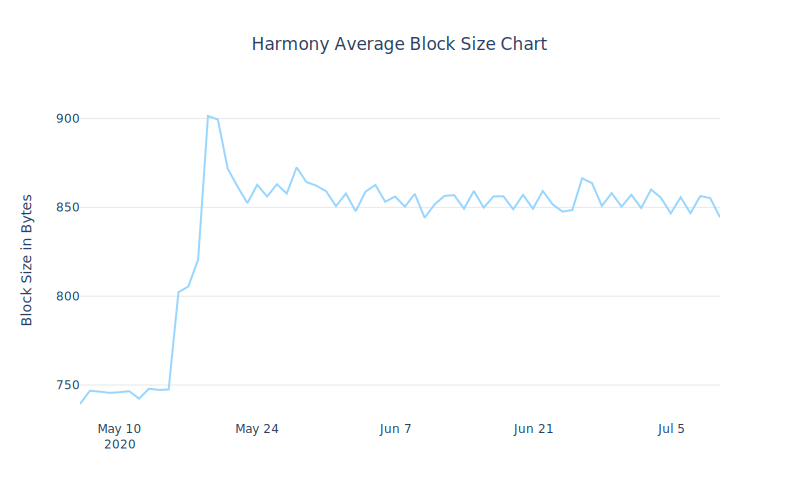

In [10]:
fig = draw_graph(df, 'avg-size','avg_size', 'Average Block Size')
fig.update_layout(yaxis_title="Block Size in Bytes")
fig.show(renderer="svg",width=800, height=500)

## Daily Volumn 

HTML saved in 


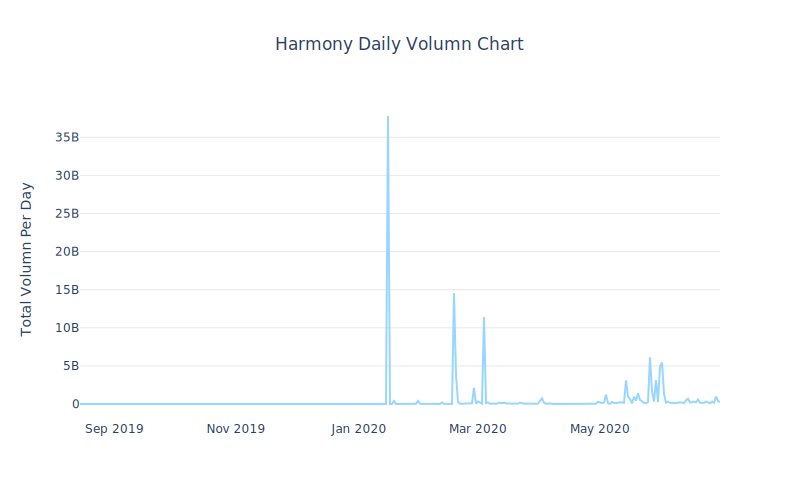

In [11]:
csv_file = "data/volumn.csv"
volumn_df = pd.read_csv(csv_file)
volumn_df['date'] = pd.to_datetime(volumn_df['date'], format='%Y-%m-%d')
fig = draw_graph(volumn_df, 'volumn', 'daily_volumn', 'Daily Volumn')
fig.update_layout(yaxis_title="Total Volumn Per Day")
fig.show(renderer="svg",width=800, height=500)

## Average Block Time

HTML saved in 


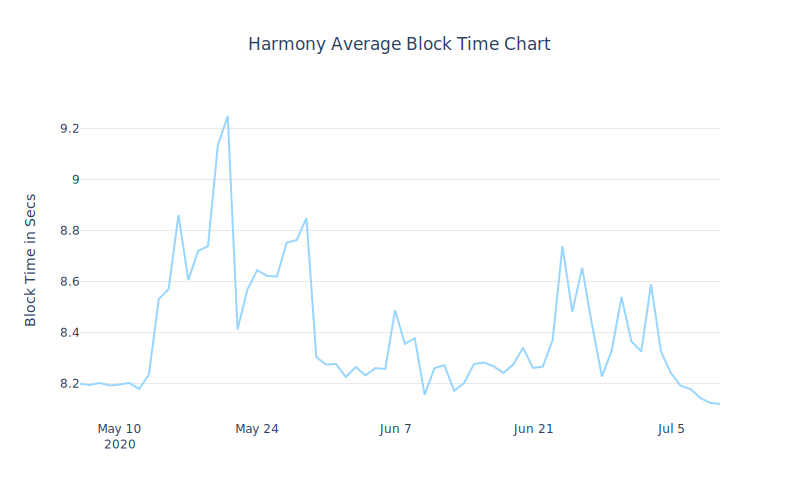

In [12]:
fig = draw_graph(df, 'avg-block-time','avg_block_time', 'Average Block Time')
fig.update_layout(yaxis_title="Block Time in Secs")
fig.show(renderer="svg",width=800, height=500)

In [13]:
colors = ["#00AEE9", "#FFA07A", "#758796", "#66CDAA"]
def draw_block_time_graph(df):
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "")
    trace1 = go.Scatter(
            x = df['date'],
            y = df['block-time-shard-0'],
            mode = 'lines',
            line = dict(color = colors[0],
                        width = 1),
            name = 'Shard 0 Block Time'
        )
    trace2 = go.Scatter(
            x = df['date'],
            y = df['block-time-shard-1'],
            mode = 'lines',
            line = dict(color = colors[1],
                        width = 1),
            name = 'Shard 1 Block Time'
        )
    trace3 = go.Scatter(
            x = df['date'],
            y = df['block-time-shard-2'],
            mode = 'lines',
            line = dict(color = colors[2],
                        width = 1),
            name = 'Shard 2 Block Time'
        )
    trace4 = go.Scatter(
            x = df['date'],
            y = df['block-time-shard-3'],
            mode = 'lines',
            line = dict(color = colors[3],
                        width = 1),
            name = 'Shard 3 Block Time'
        )
 
    data = [trace1, trace2, trace3, trace4]
    layout = go.Layout(
                title = 'Daily Avg Block Time',
                yaxis=dict(
                    title='Block Time in Secs'
                    ),
#                 legend_orientation="h", 
#                 legend=dict(x=0, y=-0.1)
            )
    fig = go.Figure(data=data, layout=layout)

#     fig.update_layout(legend_orientation="h", legend=dict(x=0, y=-0.25))
    fig.update_xaxes({'showgrid': False, 'showspikes': True, 'title': None})
    fig.update_yaxes({'gridcolor': "#E8E8E8"})
    fig.update_layout({'plot_bgcolor':'rgba(0,0,0,0)', "title_x": 0.5, 'hovermode': 'closest'})

    fig.show(renderer="svg",width=800, height=500)
    fig.write_html("{:s}daily_avg_block_time.html".format(html_dir))
    print("HTML saved in " )
    display_path = "{:s}daily_avg_block_time.html".format(html_path)
    display(HTML("<a href='" + display_path + "' target='_blank'>" + display_path + "</a>"))


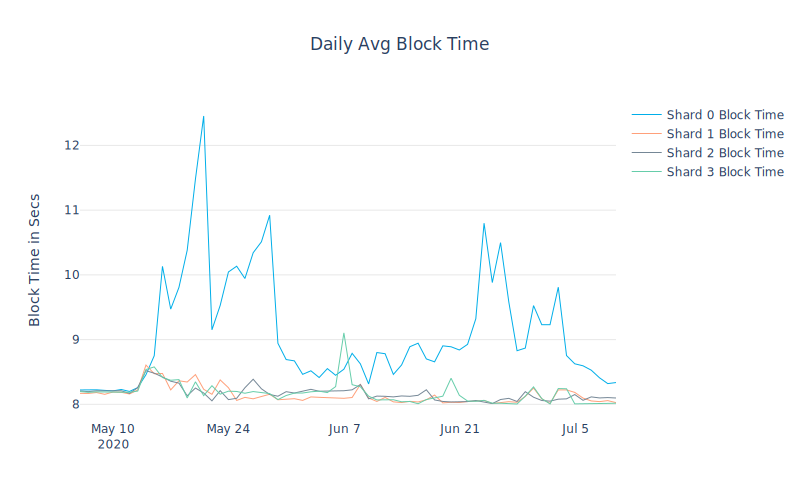

HTML saved in 


In [14]:
draw_block_time_graph(df)

## unique address

In [21]:

addr_dir = "logs/address_growth.log"
address = read_data(addr_dir)
addr_df = pd.DataFrame(address) 
addr_df["timestamp"] = pd.to_datetime(addr_df['timestamp'],format = '%Y-%m-%d')



In [24]:
addr_df.rename(columns = {'timestamp': 'date'}, inplace = True)

In [28]:
addr_df = addr_df.groupby(['date'])['count'].sum().reset_index(name = 'count')

In [31]:
addr_df['total-count'] = addr_df['count'].cumsum()

In [32]:
addr_df

,date,count,total-count
0,2019-06-28,956,956
1,2019-08-15,1,957
2,2019-08-21,6,963
3,2019-08-29,1,964
4,2019-08-30,1,965
...,...,...,...
260,2020-07-05,49,10448
261,2020-07-06,34,10482
262,2020-07-07,47,10529
263,2020-07-08,164,10693


In [15]:
addr_dir = "logs/shard0_unique_address.log"
address = read_data(addr_dir)
addr_df = pd.DataFrame(address) 
addr_df["timestamp"] = pd.to_datetime(addr_df['timestamp'],format = '%Y_%m_%d %H:%M:%S')
addr_df['date'] = addr_df['timestamp'].dt.date


HTML saved in 


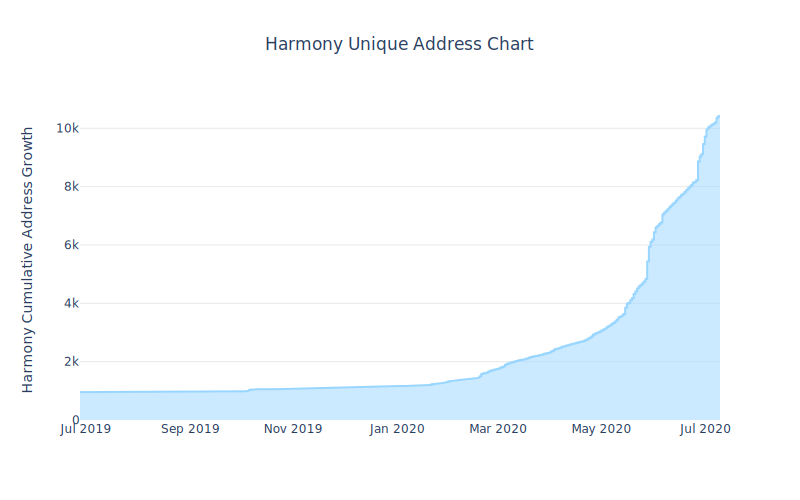

In [16]:
fig = draw_area_graph(addr_df, "count", "unique_address", "Unique Address")
fig.update_layout(yaxis_title="Harmony Cumulative Address Growth")
fig.show(renderer="svg",width=800, height=500)